# Comparison between sequence and standalone test performance

In this Notebook, I want to compare test performance between tests in the battery, applied sequentially, and their counterpart, applied as standalone. I want to investigate if there is any statistical difference between the tests in these different situations. Our expectations is that there is no significant difference between tests.

- $H_0$: Standalone tests perform the same as their battery counterpart
- $H_1$: Standalone tests do not perform the same as their battery counterpart

**Battery Suite 1** contains three tests: 
- 1) Light-Dark Box test,
- 2) Novel Tank test and
- 3) Endurance test.

In this configuration, Light-Dark Box, being the first, exists as a standalone test.

**Battery Suite 2** contains two tests: 
- 1) Novel Tank test and
- 2) Light-Dark Box test.

By simply inverting the sequence of the first two tests, we get to see the performance of Novel Tank as a standalone and Light-Dark Box as a battery counterpart.

**Battery Suite 3** evaluates Endurance test as a standalone.

In [100]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
def check_normality(df, cols):
    """
    Perform Shapiro-Wilk test for normality on specified columns of a DataFrame.
    
    Parameters:
    df : pandas.DataFrame
        The DataFrame containing the data.
    cols : str or list of str
        The column(s) to check for normality.
    """
    # If a single column is passed, convert to list for uniform processing
    if isinstance(cols, str):
        cols = [cols]    
    # Iterate through the columns and perform Shapiro-Wilk test
    for col in cols:
        stat, p_value = shapiro(df[col])
        print(f"Shapiro-Wilk Test for '{col}':")
        print(f"  Test statistic: {stat:.3f}, p-value: {p_value:.3f}")        
        # Interpretation of p-value
        if p_value > 0.05:
            print(f"  '{col}' appears to be normally distributed.\n")
        else:
            print(f"  '{col}' does not appear to be normally distributed.\n")

def run_test(df1, col1, df2, col2, alpha):
    data1 = df1[col1].dropna()
    data2 = df2[col2].dropna()

    min_len = min(len(data1), len(data2))
    data1 = data1[:min_len]
    data2 = data2[:min_len]

    stat, p_value = mannwhitneyu(data1, data2)

    if p_value < alpha:
        return f'There is a significant difference between {col1} in df1 and {col2} in df2 (p-value: {p_value:.4f})'
    else:
        return f'There is no significant difference between {col1} in df1 and {col2} in df2 (p-value: {p_value:.4f})'


def compare(df1, df2, col, alpha):
    groups = df1['group'].unique()

    for group in groups:
        df1_group = df1[df1['group'] == group]
        df2_group = df2[df2['group'] == group]
        result = run_test(df1_group, col, df2_group, col, alpha)
        print(f'Group: {group} - {result}')

In [2]:
# load all three dataframes
bt1 = pd.read_csv('battery_suite_1.csv')
bt2 = pd.read_csv('battery_suite_2.csv')
bt3 = pd.read_csv('battery_suite_3.csv')

## Random Things

In [4]:
bt1.columns

Index(['Unnamed: 0', 'fish_id', 'group', 'treatment', 'exposure', 'datetime',
       'latency', 'first_choice', 'num_changes', 'time_bright', 'mtpc',
       'mov_bottom', 'mov_upper', 'mov_total', 'dist_bottom', 'dist_upper',
       'dist_total', 'vel_bottom', 'vel_upper', 'vel_mean', 'attempts',
       'last_flux', 'time_in_last_flux', 'resistance_index', 'lt', 'ls', 'wt',
       'Kc', 'sex', 'blood_sugar', 'conductivity', 'pH'],
      dtype='object')

In [25]:
# filter for features we are focusing on
bt1 = bt1[['group', 'treatment', 'exposure', 'latency', 'first_choice', 'num_changes', 'time_bright', 'mtpc',
       'mov_bottom', 'mov_upper', 'mov_total', 'dist_bottom', 'dist_upper',
       'dist_total', 'vel_bottom', 'vel_upper', 'vel_mean', 'attempts',
       'last_flux', 'time_in_last_flux', 'resistance_index']]

bt2 = bt2[['group', 'treatment', 'exposure', 'latency', 'first_choice', 'num_changes', 'time_bright', 'mtpc',
       'mov_bottom', 'mov_upper', 'mov_total', 'dist_bottom', 'dist_upper',
       'dist_total', 'vel_bottom', 'vel_upper', 'vel_mean']]

bt3 = bt3[['group', 'treatment', 'exposure', 'attempts',
       'last_flux', 'time_in_last_flux', 'resistance_index']]

### Light-Dark Box

In [26]:
ldb = bt1[['group', 'latency', 'first_choice', 'num_changes', 'time_bright', 'mtpc']]
ldb2 = bt2[['group', 'latency', 'first_choice', 'num_changes', 'time_bright', 'mtpc']]

ldb2 = ldb2.rename(columns={
    'latency' : 'latency_2',
    'first_choice' : 'first_choice_2',
    'num_changes' : 'num_changes_2',
    'time_bright' : 'time_bright_2',
    'mtpc' : 'mtpc_2'
})

In [27]:
ldb.dtypes

group            object
latency         float64
first_choice     object
num_changes     float64
time_bright     float64
mtpc            float64
dtype: object

In [28]:
ldb2.dtypes

group              object
latency_2         float64
first_choice_2     object
num_changes_2     float64
time_bright_2     float64
mtpc_2            float64
dtype: object

In [12]:
assert set(ldb['group']) == set(ldb2['group'])

In [29]:
ldb.reset_index(drop=True, inplace=True)
ldb2.reset_index(drop=True, inplace=True)

In [31]:
ldb = pd.concat([ldb, ldb2[['latency_2', 'first_choice_2', 'num_changes_2', 'time_bright_2', 'mtpc_2']]], axis=1)

In [35]:
ldb.columns

Index(['group', 'latency', 'first_choice', 'num_changes', 'time_bright',
       'mtpc', 'latency_2', 'first_choice_2', 'num_changes_2', 'time_bright_2',
       'mtpc_2'],
      dtype='object')

In [36]:
ldb = ldb[['group', 'latency', 'latency_2', 'first_choice', 'first_choice_2', 'num_changes', 'num_changes_2', 'time_bright', 'time_bright_2', 'mtpc', 'mtpc_2']]

In [51]:
ldb = ldb.dropna()

In [53]:
check_normality(ldb, ['latency', 'latency_2', 'num_changes', 'num_changes_2', 'time_bright', 'time_bright_2', 'mtpc', 'mtpc_2'])

Shapiro-Wilk Test for 'latency':
  Test statistic: 0.383, p-value: 0.000
  'latency' does not appear to be normally distributed.

Shapiro-Wilk Test for 'latency_2':
  Test statistic: 0.212, p-value: 0.000
  'latency_2' does not appear to be normally distributed.

Shapiro-Wilk Test for 'num_changes':
  Test statistic: 0.915, p-value: 0.000
  'num_changes' does not appear to be normally distributed.

Shapiro-Wilk Test for 'num_changes_2':
  Test statistic: 0.865, p-value: 0.000
  'num_changes_2' does not appear to be normally distributed.

Shapiro-Wilk Test for 'time_bright':
  Test statistic: 0.949, p-value: 0.000
  'time_bright' does not appear to be normally distributed.

Shapiro-Wilk Test for 'time_bright_2':
  Test statistic: 0.951, p-value: 0.000
  'time_bright_2' does not appear to be normally distributed.

Shapiro-Wilk Test for 'mtpc':
  Test statistic: 0.356, p-value: 0.000
  'mtpc' does not appear to be normally distributed.

Shapiro-Wilk Test for 'mtpc_2':
  Test statistic: 0.

In [59]:
# sellecting groups to compare
bt1_1 = bt1.loc[bt1.group == '01h 0.0%']
bt1_2 = bt1.loc[bt1.group == '01h 0.5%']
bt1_3 = bt1.loc[bt1.group == '01h 1.0%']
bt1_4 = bt1.loc[bt1.group == '24h 0.0%']
bt1_5 = bt1.loc[bt1.group == '24h 0.5%']
bt1_6 = bt1.loc[bt1.group == '24h 1.0%']
bt1_7 = bt1.loc[bt1.group == '96h 0.0%']
bt1_8 = bt1.loc[bt1.group == '96h 0.5%']
bt1_9 = bt1.loc[bt1.group == '96h 1.0%']

In [60]:
bt2_1 = bt2.loc[bt2.group == '01h 0.0%']
bt2_2 = bt2.loc[bt2.group == '01h 0.5%']
bt2_3 = bt2.loc[bt2.group == '01h 1.0%']
bt2_4 = bt2.loc[bt2.group == '24h 0.0%']
bt2_5 = bt2.loc[bt2.group == '24h 0.5%']
bt2_6 = bt2.loc[bt2.group == '24h 1.0%']
bt2_7 = bt2.loc[bt2.group == '96h 0.0%']
bt2_8 = bt2.loc[bt2.group == '96h 0.5%']
bt2_9 = bt2.loc[bt2.group == '96h 1.0%']

## Really Testing

### Light-Dark Box (different)

#### Latency (no difference)

In [80]:
# latency overall
run_test(bt1, 'latency', bt2, 'latency', 0.05)

'There is no significant difference between latency in df1 and latency in df2 (p-value: 0.1069)'

In [75]:
# latency per group
compare(bt1, bt2, 'latency', 0.05)

Group: 01h 0.0% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.2575)
Group: 01h 0.5% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.2980)
Group: 01h 1.0% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.2850)
Group: 24h 0.0% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.0797)
Group: 24h 0.5% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.3799)
Group: 24h 1.0% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.8389)
Group: 96h 0.0% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.4982)
Group: 96h 0.5% - There is no significant difference between latency in df1 and latency in df2 (p-value: 0.4329)
Group: 96h 1.0% - There is no significant difference between latency in df1 and latency in df2 (

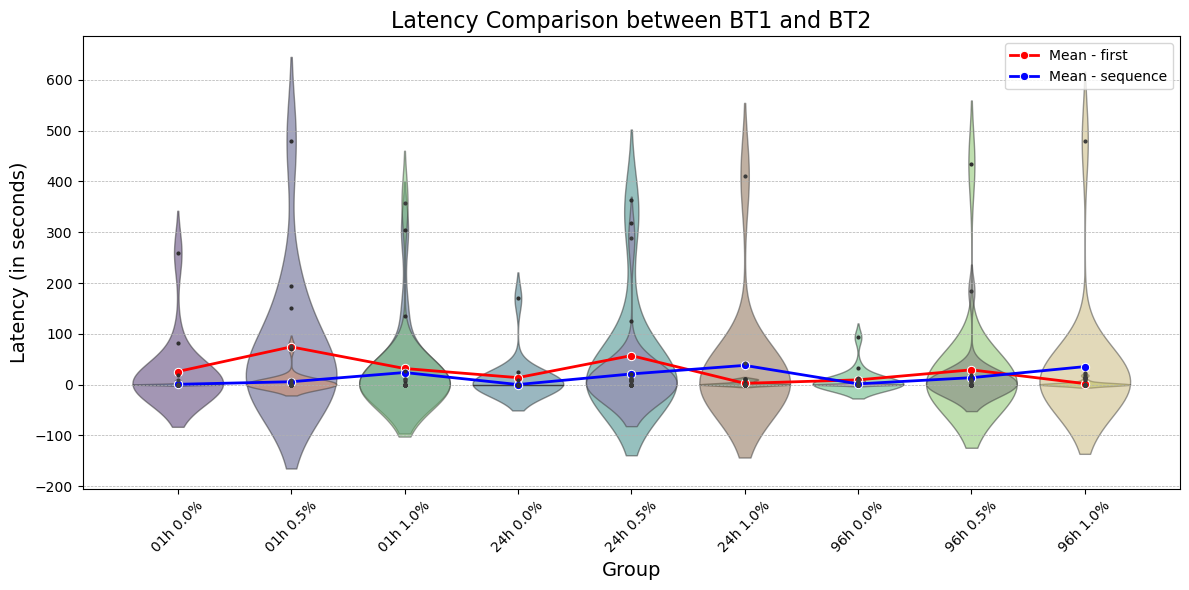

In [178]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
latency_means_bt1 = bt1.groupby('group')['latency'].mean().reset_index()
latency_means_bt2 = bt2.groupby('group')['latency'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='latency', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='latency', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (latency)
sns.lineplot(data=latency_means_bt1, x='group', y='latency', color='red', marker='o', label='Mean - first', linewidth=2)
sns.lineplot(data=latency_means_bt2, x='group', y='latency', color='blue', marker='o', label='Mean - sequence', linewidth=2)

# Customize plot
plt.title('Latency Comparison between BT1 and BT2', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Latency (in seconds)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### First Choice

#### Number of Changes (minor difference)

In [81]:
# num_changes overall
run_test(bt1, 'num_changes', bt2, 'num_changes', 0.05)

'There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.1194)'

In [76]:
# num_changes per group
compare(bt1, bt2, 'num_changes', 0.05)

Group: 01h 0.0% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.2502)
Group: 01h 0.5% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.8648)
Group: 01h 1.0% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.8061)
Group: 24h 0.0% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.4926)
Group: 24h 0.5% - There is a significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.0108)
Group: 24h 1.0% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.8851)
Group: 96h 0.0% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.1262)
Group: 96h 0.5% - There is no significant difference between num_changes in df1 and num_changes in df2 (p-value: 0.4972)
Group: 96h 1.0% - There is no sig

In [98]:
num_changes_1 = bt1.groupby('group')['num_changes'].agg(['min', 'median', 'max', 'mean', 'std']).reset_index().round(2)
num_changes_1.loc[num_changes_1['group'] == '24h 0.5%']

,group,min,median,max,mean,std
4,24h 0.5%,0.0,26.0,45.0,21.27,13.91


In [94]:
num_changes_2 = bt2.groupby('group')['num_changes'].agg(['min', 'median', 'max', 'mean', 'std']).reset_index().round(2)
num_changes_2.loc[num_changes_2['group'] == '24h 0.5%']

,group,min,median,max,mean,std
4,24h 0.5%,0.0,3.0,32.0,7.38,9.0


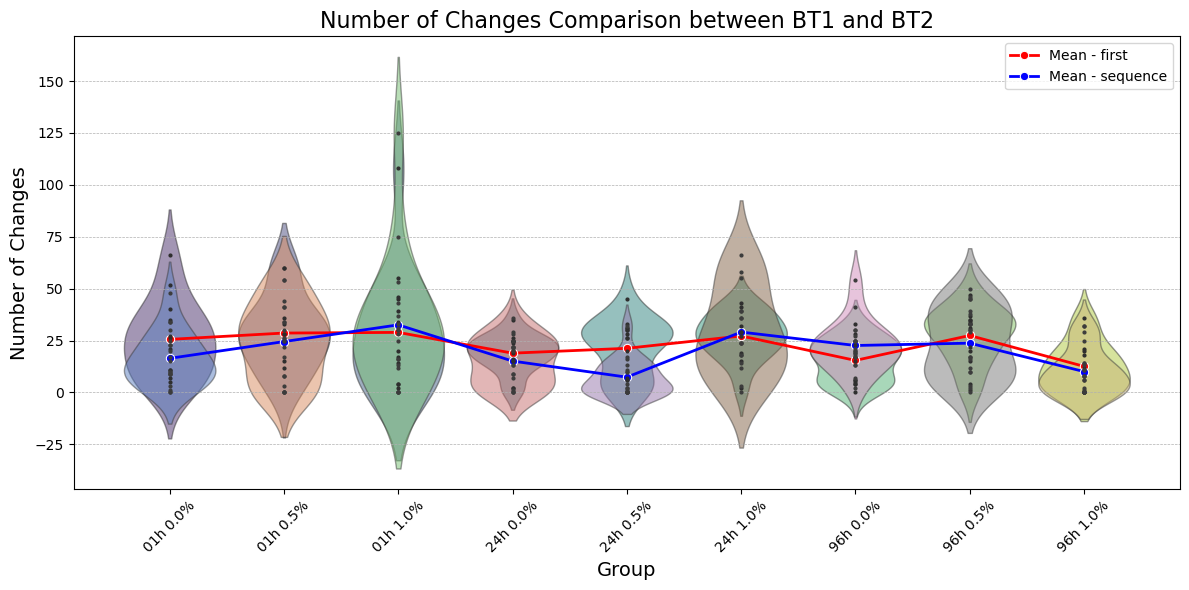

In [177]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
num_changes_means_bt1 = bt1.groupby('group')['num_changes'].mean().reset_index()
num_changes_means_bt2 = bt2.groupby('group')['num_changes'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='num_changes', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='num_changes', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (num_changes)
sns.lineplot(data=num_changes_means_bt1, x='group', y='num_changes', color='red', marker='o', label='Mean - first', linewidth=2)
sns.lineplot(data=num_changes_means_bt2, x='group', y='num_changes', color='blue', marker='o', label='Mean - sequence', linewidth=2)

# Customize plot
plt.title('Number of Changes Comparison between BT1 and BT2', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Number of Changes', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

I wonder if the difference spotted in 24h 0.5% could be related to factors that are not the test going first or second in a battery. First guess would be fish size

In [109]:
full_bt1 = pd.read_csv('battery_suite_1.csv')
full_bt2 = pd.read_csv('battery_suite_2.csv')

In [115]:
Kc_1 = full_bt1.groupby('group')['Kc'].agg(['min', 'median', 'max', 'mean', 'std']).round(2)
Kc_1.loc[Kc_1.index == '24h 0.5%']

,min,median,max,mean,std
group,,,,,
24h 0.5%,1.28,1.57,2.11,1.61,0.2


In [116]:
Kc_2 = full_bt2.groupby('group')['Kc'].agg(['min', 'median', 'max', 'mean', 'std']).round(2)
Kc_2.loc[Kc_2.index == '24h 0.5%']

,min,median,max,mean,std
group,,,,,
24h 0.5%,1.6,2.0,5.83,2.22,0.99


In [126]:
print(f' BT1 mean fish size: {full_bt1.groupby('group')['ls'].mean().round(2)} \nBT2 mean fish size: {full_bt2.groupby('group')['ls'].mean().round(2)}')

 BT1 mean fish size: group
01h 0.0%    2.94
01h 0.5%    2.86
01h 1.0%    2.96
24h 0.0%    2.97
24h 0.5%    2.97
24h 1.0%    2.38
96h 0.0%    2.62
96h 0.5%    2.51
96h 1.0%    2.59
Name: ls, dtype: float64 
BT2 mean fish size: group
01h 0.0%    2.30
01h 0.5%    2.36
01h 1.0%    2.31
24h 0.0%    2.22
24h 0.5%    2.19
24h 1.0%    2.85
96h 0.0%    2.32
96h 0.5%    2.40
96h 1.0%    2.20
Name: ls, dtype: float64


Interestingly, the difference between 24h 0.5% in BT1 and BT2 could be related to fish size, as it is, after all, the biggest difference in all of the groups.

#### Time in Bright (major difference!!!)

In [79]:
# time_brigh overall
run_test(bt1, 'time_bright', bt2, 'time_bright', 0.05)

'There is a significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.0004)'

In [77]:
# time_bright per group
compare(bt1, bt2, 'time_bright', 0.05)

Group: 01h 0.0% - There is no significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.4347)
Group: 01h 0.5% - There is a significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.0474)
Group: 01h 1.0% - There is no significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.0796)
Group: 24h 0.0% - There is a significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.0090)
Group: 24h 0.5% - There is no significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.2453)
Group: 24h 1.0% - There is no significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.2366)
Group: 96h 0.0% - There is no significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.2206)
Group: 96h 0.5% - There is no significant difference between time_bright in df1 and time_bright in df2 (p-value: 0.5591)
Group: 96h 1.0% - There is no sign

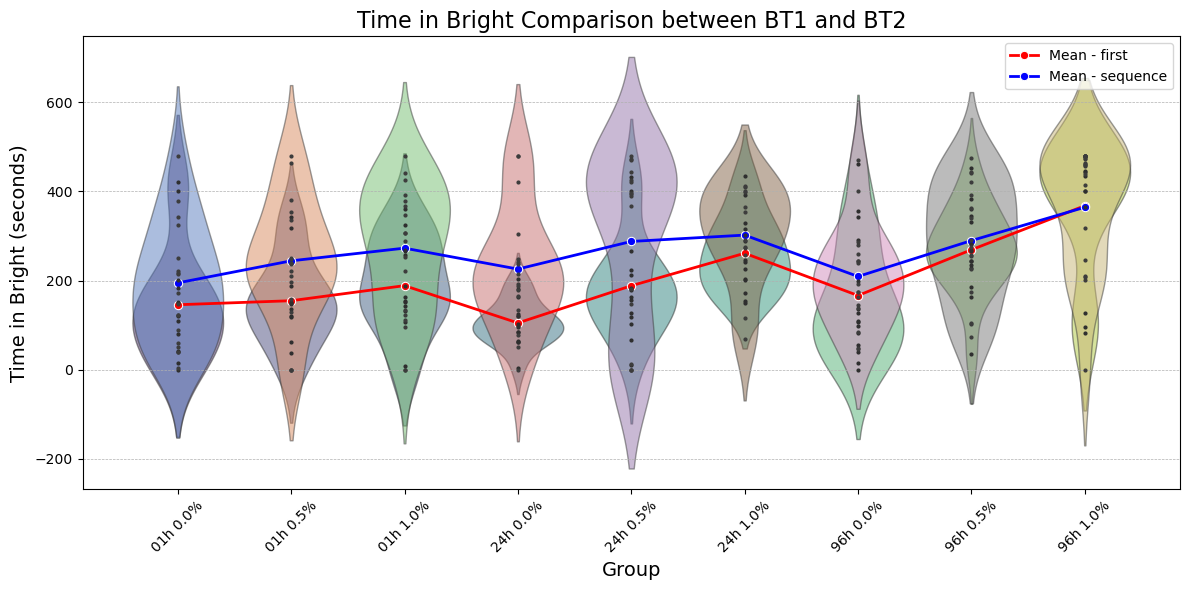

In [179]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
time_bright_means_bt1 = bt1.groupby('group')['time_bright'].mean().reset_index()
time_bright_means_bt2 = bt2.groupby('group')['time_bright'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='time_bright', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='time_bright', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (time_bright)
sns.lineplot(data=time_bright_means_bt1, x='group', y='time_bright', color='red', marker='o', label='Mean - first', linewidth=2)
sns.lineplot(data=time_bright_means_bt2, x='group', y='time_bright', color='blue', marker='o', label='Mean - sequence', linewidth=2)

# Customize plot
plt.title('Time in Bright Comparison between BT1 and BT2', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Time in Bright (seconds)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### Mean Time per Change (different)

In [128]:
run_test(bt1, 'mtpc', bt2, 'mtpc', 0.05)

'There is a significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.0007)'

In [129]:
compare(bt1, bt2, 'mtpc', 0.05)

Group: 01h 0.0% - There is a significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.0432)
Group: 01h 0.5% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.1171)
Group: 01h 1.0% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.2998)
Group: 24h 0.0% - There is a significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.0144)
Group: 24h 0.5% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.1842)
Group: 24h 1.0% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.7075)
Group: 96h 0.0% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.8358)
Group: 96h 0.5% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.8065)
Group: 96h 1.0% - There is no significant difference between mtpc in df1 and mtpc in df2 (p-value: 0.2566)


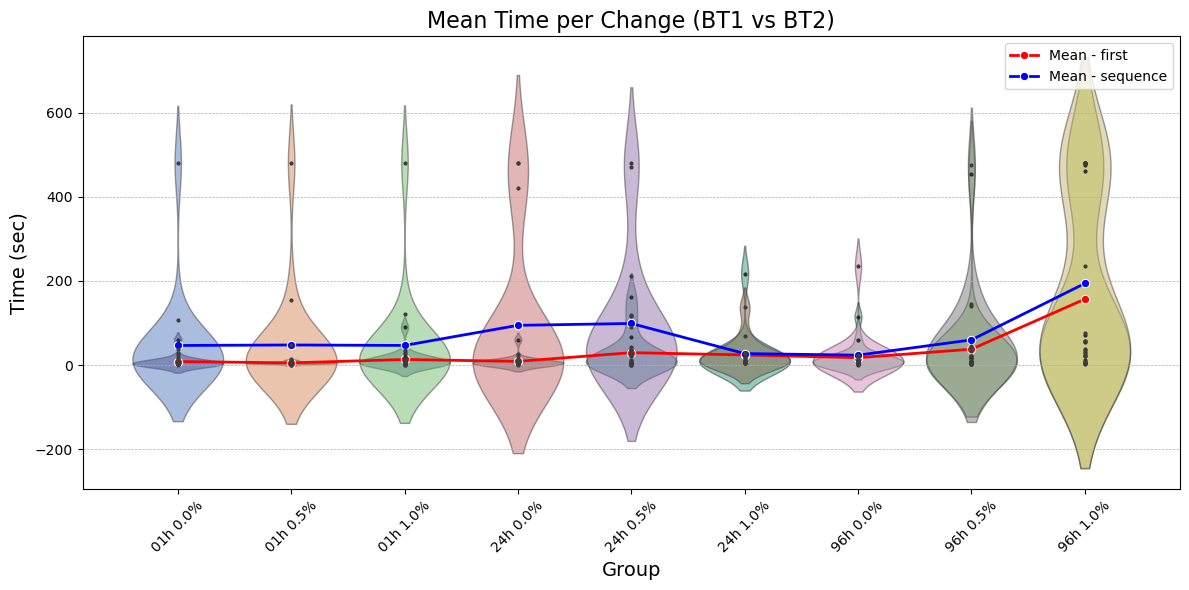

In [180]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
mtpc_means_bt1 = bt1.groupby('group')['mtpc'].mean().reset_index()
mtpc_means_bt2 = bt2.groupby('group')['mtpc'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='mtpc', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='mtpc', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (mtpc)
sns.lineplot(data=mtpc_means_bt1, x='group', y='mtpc', color='red', marker='o', label='Mean - first', linewidth=2)
sns.lineplot(data=mtpc_means_bt2, x='group', y='mtpc', color='blue', marker='o', label='Mean - sequence', linewidth=2)

# Customize plot
plt.title('Mean Time per Change (BT1 vs BT2)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Time (sec)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Novel Tank (different)

In [154]:
drop_this = bt1.loc[bt1.vel_mean == 0]

In [155]:
bt1_clean = bt1.drop(drop_this.index, inplace=True)

In [131]:
bt1.columns

Index(['group', 'treatment', 'exposure', 'latency', 'first_choice',
       'num_changes', 'time_bright', 'mtpc', 'mov_bottom', 'mov_upper',
       'mov_total', 'dist_bottom', 'dist_upper', 'dist_total', 'vel_bottom',
       'vel_upper', 'vel_mean', 'attempts', 'last_flux', 'time_in_last_flux',
       'resistance_index'],
      dtype='object')

#### Time Spent Moving (major difference)

In [156]:
run_test(bt1, 'mov_total', bt2, 'mov_total', 0.05)

'There is a significant difference between mov_total in df1 and mov_total in df2 (p-value: 0.0000)'

In [157]:
run_test(bt1, 'mov_upper', bt2, 'mov_upper', 0.05)

'There is no significant difference between mov_upper in df1 and mov_upper in df2 (p-value: 0.8183)'

In [158]:
run_test(bt1, 'mov_bottom', bt2, 'mov_bottom', 0.05)

'There is a significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.0010)'

In [159]:
compare(bt1, bt2, 'mov_bottom', 0.05)

Group: 01h 0.0% - There is no significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.9450)
Group: 01h 0.5% - There is no significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.1998)
Group: 01h 1.0% - There is no significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.1646)
Group: 24h 0.0% - There is a significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.0181)
Group: 24h 0.5% - There is a significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.0000)
Group: 24h 1.0% - There is no significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.5067)
Group: 96h 0.0% - There is no significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.6784)
Group: 96h 0.5% - There is no significant difference between mov_bottom in df1 and mov_bottom in df2 (p-value: 0.6784)
Group: 96h 1.0% - There is no significant differen

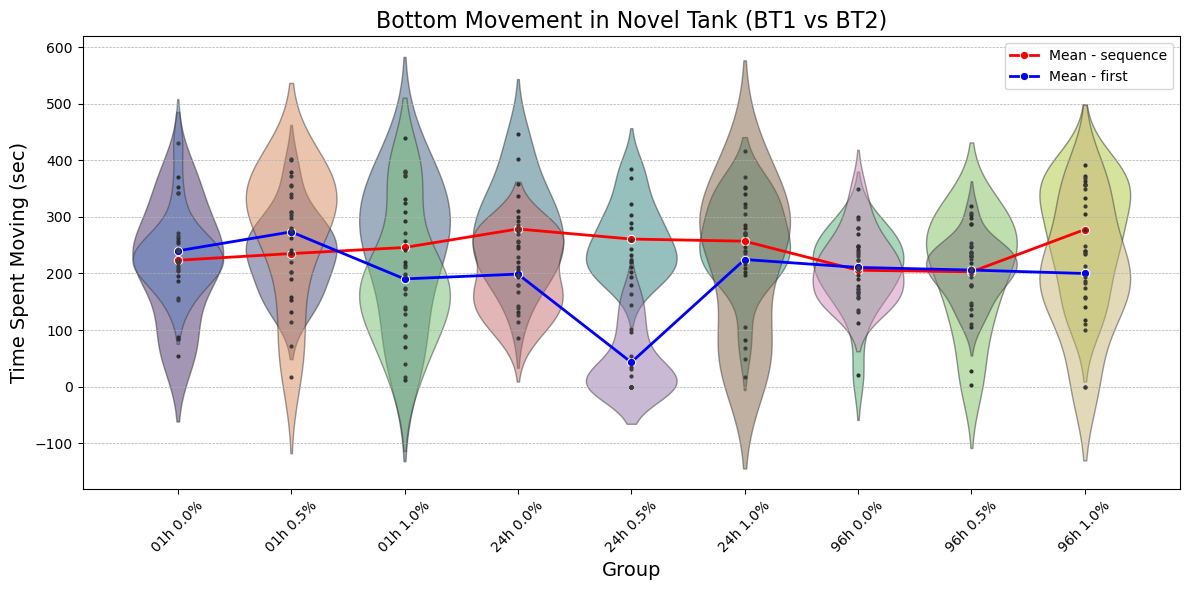

In [181]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
mov_bottom_means_bt1 = bt1.groupby('group')['mov_bottom'].mean().reset_index()
mov_bottom_means_bt2 = bt2.groupby('group')['mov_bottom'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='mov_bottom', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='mov_bottom', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (mov_bottom)
sns.lineplot(data=mov_bottom_means_bt1, x='group', y='mov_bottom', color='red', marker='o', label='Mean - sequence', linewidth=2)
sns.lineplot(data=mov_bottom_means_bt2, x='group', y='mov_bottom', color='blue', marker='o', label='Mean - first', linewidth=2)

# Customize plot
plt.title('Bottom Movement in Novel Tank (BT1 vs BT2)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Time Spent Moving (sec)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### Velocity (huge difference)

In [161]:
run_test(bt1, 'vel_mean', bt2, 'vel_mean', 0.05)

'There is a significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.0482)'

In [162]:
compare(bt1, bt2, 'vel_mean', 0.05)

Group: 01h 0.0% - There is a significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.0108)
Group: 01h 0.5% - There is no significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.3299)
Group: 01h 1.0% - There is no significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.2628)
Group: 24h 0.0% - There is no significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.1711)
Group: 24h 0.5% - There is no significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.0971)
Group: 24h 1.0% - There is no significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.2145)
Group: 96h 0.0% - There is no significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.3000)
Group: 96h 0.5% - There is a significant difference between vel_mean in df1 and vel_mean in df2 (p-value: 0.0185)
Group: 96h 1.0% - There is no significant difference between vel_mean in df1 and v

In [163]:
run_test(bt1, 'vel_bottom', bt2, 'vel_bottom', 0.05)

'There is a significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.0004)'

In [164]:
compare(bt1, bt2, 'vel_bottom', 0.05)

Group: 01h 0.0% - There is a significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.0123)
Group: 01h 0.5% - There is no significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.6444)
Group: 01h 1.0% - There is no significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.5069)
Group: 24h 0.0% - There is a significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.0465)
Group: 24h 0.5% - There is no significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.5054)
Group: 24h 1.0% - There is no significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.1260)
Group: 96h 0.0% - There is no significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.3558)
Group: 96h 0.5% - There is no significant difference between vel_bottom in df1 and vel_bottom in df2 (p-value: 0.0864)
Group: 96h 1.0% - There is no significant differen

In [165]:
run_test(bt1, 'vel_upper', bt2, 'vel_upper', 0.05)

'There is a significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.0459)'

In [166]:
compare(bt1, bt2, 'vel_upper', 0.05)

Group: 01h 0.0% - There is a significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.0304)
Group: 01h 0.5% - There is a significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.0028)
Group: 01h 1.0% - There is no significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 1.0000)
Group: 24h 0.0% - There is no significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.2603)
Group: 24h 0.5% - There is a significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.0159)
Group: 24h 1.0% - There is no significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.3447)
Group: 96h 0.0% - There is no significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.5591)
Group: 96h 0.5% - There is a significant difference between vel_upper in df1 and vel_upper in df2 (p-value: 0.0014)
Group: 96h 1.0% - There is a significant difference between vel_uppe

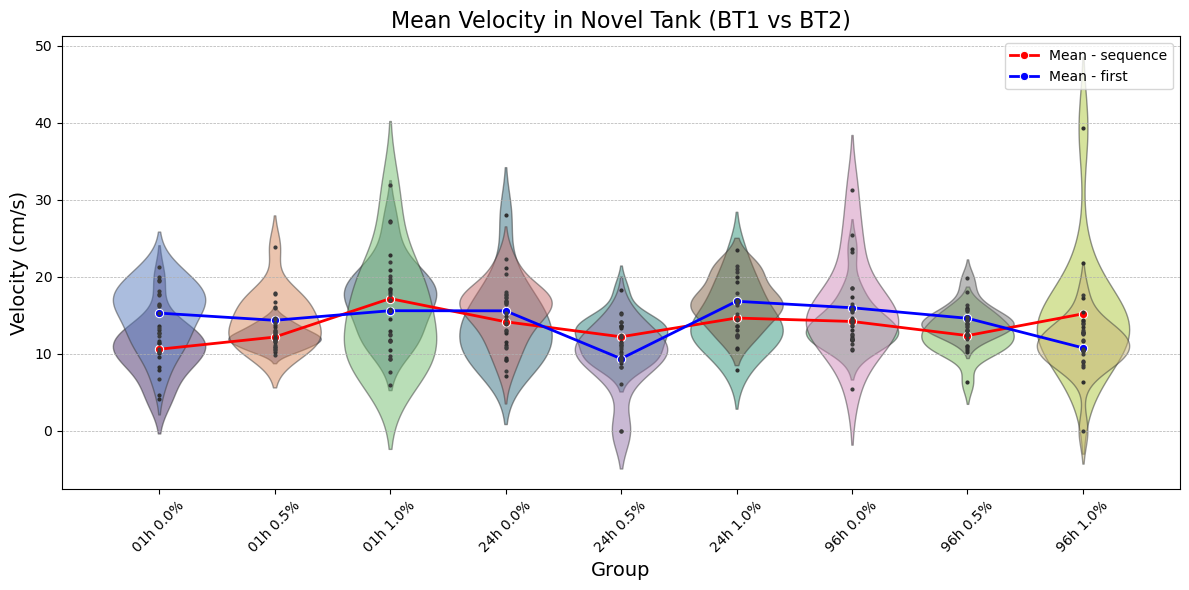

In [182]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
vel_mean_means_bt1 = bt1.groupby('group')['vel_mean'].mean().reset_index()
vel_mean_means_bt2 = bt2.groupby('group')['vel_mean'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='vel_mean', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='vel_mean', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (vel_mean)
sns.lineplot(data=vel_mean_means_bt1, x='group', y='vel_mean', color='red', marker='o', label='Mean - sequence', linewidth=2)
sns.lineplot(data=vel_mean_means_bt2, x='group', y='vel_mean', color='blue', marker='o', label='Mean - first', linewidth=2)

# Customize plot
plt.title('Mean Velocity in Novel Tank (BT1 vs BT2)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Velocity (cm/s)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

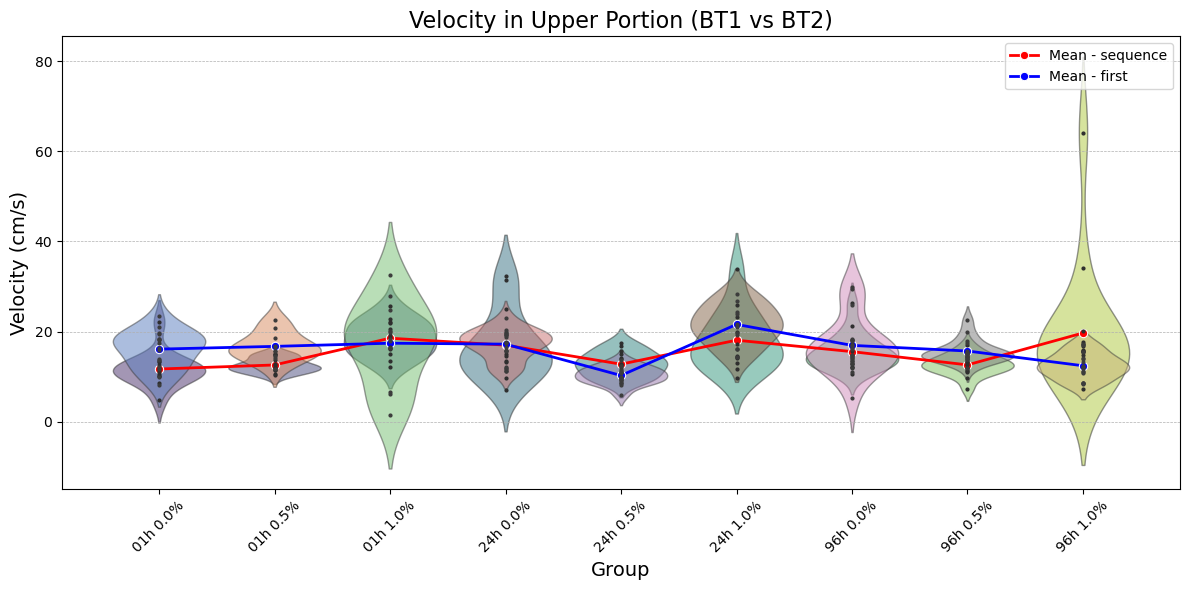

In [183]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
vel_upper_means_bt1 = bt1.groupby('group')['vel_upper'].mean().reset_index()
vel_upper_means_bt2 = bt2.groupby('group')['vel_upper'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='vel_upper', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='vel_upper', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (vel_upper)
sns.lineplot(data=vel_upper_means_bt1, x='group', y='vel_upper', color='red', marker='o', label='Mean - sequence', linewidth=2)
sns.lineplot(data=vel_upper_means_bt2, x='group', y='vel_upper', color='blue', marker='o', label='Mean - first', linewidth=2)

# Customize plot
plt.title('Velocity in Upper Portion (BT1 vs BT2)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Velocity (cm/s)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### Distance (somewhat different)

In [172]:
run_test(bt1, 'dist_total', bt2, 'dist_total', 0.05)

'There is no significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.5677)'

In [173]:
run_test(bt1, 'dist_upper', bt2, 'dist_upper', 0.05)

'There is no significant difference between dist_upper in df1 and dist_upper in df2 (p-value: 0.2473)'

In [174]:
run_test(bt1, 'dist_bottom', bt2, 'dist_bottom', 0.05)

'There is no significant difference between dist_bottom in df1 and dist_bottom in df2 (p-value: 0.6076)'

In [175]:
compare(bt1, bt2, 'dist_total', 0.05)

Group: 01h 0.0% - There is a significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.0159)
Group: 01h 0.5% - There is no significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.2382)
Group: 01h 1.0% - There is a significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.0381)
Group: 24h 0.0% - There is no significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.3837)
Group: 24h 0.5% - There is a significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.0279)
Group: 24h 1.0% - There is no significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.7075)
Group: 96h 0.0% - There is no significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.8653)
Group: 96h 0.5% - There is a significant difference between dist_total in df1 and dist_total in df2 (p-value: 0.0122)
Group: 96h 1.0% - There is no significant difference

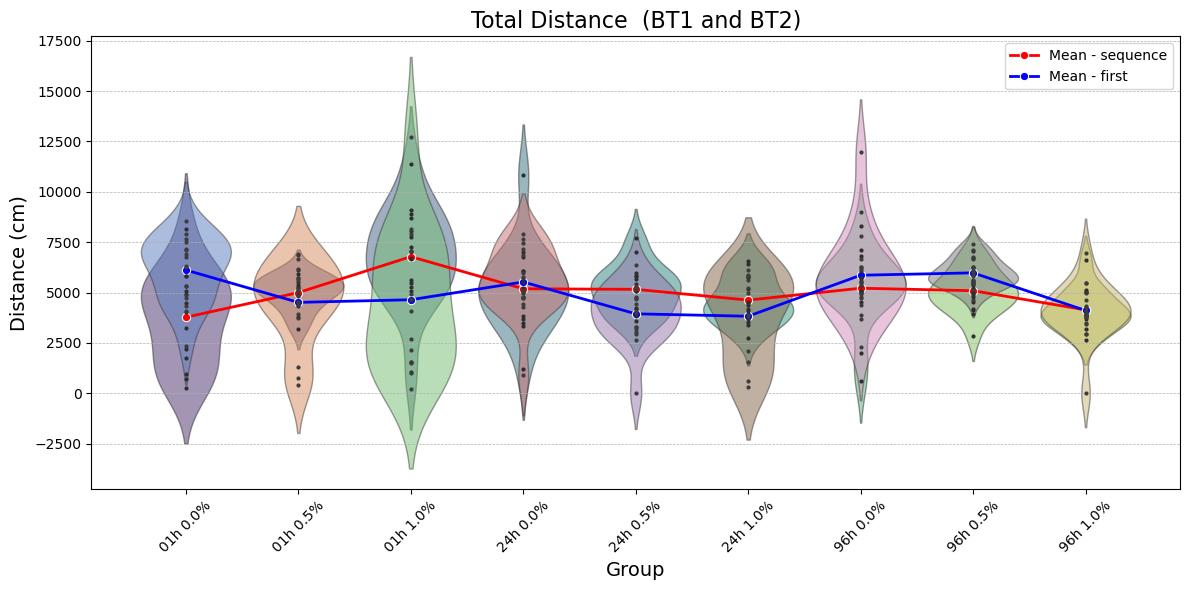

In [184]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
dist_total_means_bt1 = bt1.groupby('group')['dist_total'].mean().reset_index()
dist_total_means_bt2 = bt2.groupby('group')['dist_total'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='dist_total', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt2, x='group', y='dist_total', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (dist_total)
sns.lineplot(data=dist_total_means_bt1, x='group', y='dist_total', color='red', marker='o', label='Mean - sequence', linewidth=2)
sns.lineplot(data=dist_total_means_bt2, x='group', y='dist_total', color='blue', marker='o', label='Mean - first', linewidth=2)

# Customize plot
plt.title('Total Distance  (BT1 and BT2)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Distance (cm)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

While the overall comparison (without taking exposure and treatment into account) didn't point to a significant difference, a more close look did. And it's not irrelevant that the significant differences were all for groups under alcohol influence. Plus, a look at the graphic will show a total shift of the observed effect. Look, mean distance goes down with alcohol exposure to 1h and 24h in the test going first, while the same treatment brings those mean down. More importantly, even in 96h there is a signinificant difference in 0.5%.

### Endurance (huge different)

In [186]:
run_test(bt1, 'resistance_index', bt3, 'resistance_index', 0.05)

'There is a significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.0000)'

In [187]:
compare(bt1, bt3, 'resistance_index', 0.05)

Group: 01h 0.0% - There is a significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.0409)
Group: 01h 0.5% - There is a significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.0021)
Group: 01h 1.0% - There is a significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.0028)
Group: 24h 0.0% - There is a significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.0180)
Group: 24h 0.5% - There is a significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.0010)
Group: 24h 1.0% - There is no significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.5444)
Group: 96h 0.0% - There is no significant difference between resistance_index in df1 and resistance_index in df2 (p-value: 0.3558)
Group: 96h 0.5% - There is a significant difference between resistance_index in df1 and 

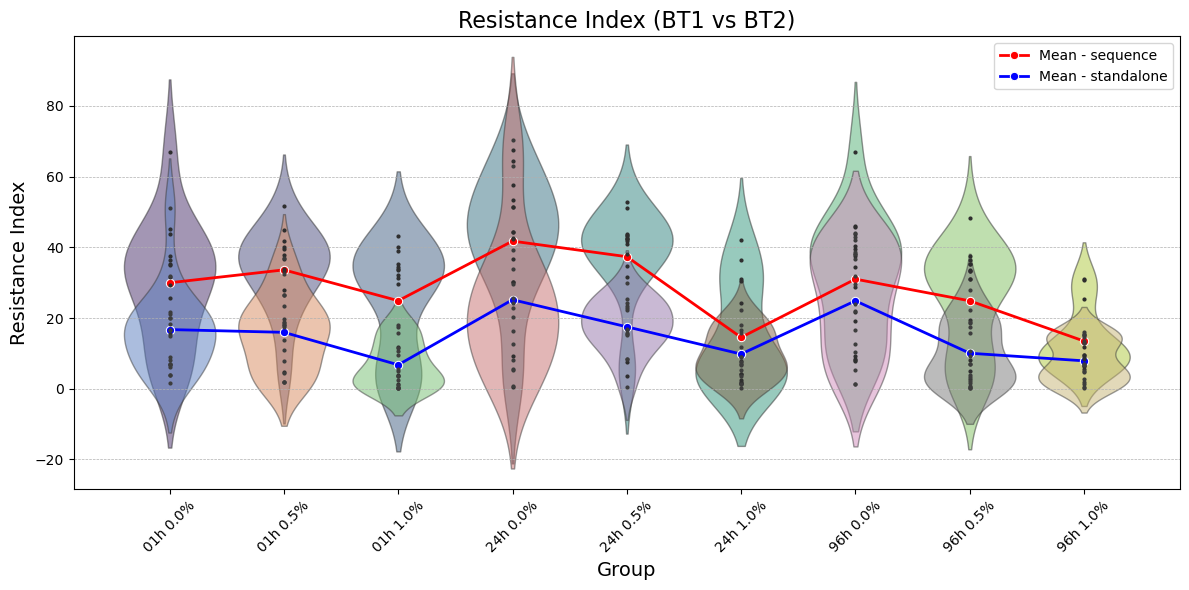

In [190]:
# Assuming 'bt1' and 'bt2' have the same structure and group column
resistance_index_means_bt1 = bt1.groupby('group')['resistance_index'].mean().reset_index()
resistance_index_means_bt3 = bt3.groupby('group')['resistance_index'].mean().reset_index()

plt.figure(figsize=(12, 6))

# Plot the violins for both bt1 and bt2 with transparency
sns.violinplot(data=bt1, x='group', y='resistance_index', palette='viridis', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)
sns.violinplot(data=bt3, x='group', y='resistance_index', palette='muted', hue='group', inner='point', linewidth=1, alpha=0.5, dodge=False)

# Plot the means for bt1 and bt2 (resistance_index)
sns.lineplot(data=resistance_index_means_bt1, x='group', y='resistance_index', color='red', marker='o', label='Mean - sequence', linewidth=2)
sns.lineplot(data=resistance_index_means_bt3, x='group', y='resistance_index', color='blue', marker='o', label='Mean - standalone', linewidth=2)

# Customize plot
plt.title('Resistance Index (BT1 vs BT2)', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Resistance Index', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

Even though they are quite different, the trending still looks the same. Seems that going in sequence activates the fish and makes them swim harder, but the patterns are relatively stable between groups. My interpretation is that the test looses sensibility, but retains its accuracy somehow.

# Conclusion

It is quite hard to draw a conclusion here. Overall, the tests performed significantly differently. It seems, though, that some parameters are more sensible to test allocation than others. Important is, some tests have "core" parameters, and it seems that those are the most sensible. Test allocation even shifted the interpretation results in some cases (e.g., Velocity in Novel Tank). Surprinsingly, Novel Tank took the hardest hit from changing places, followed by Light-Dark Box and Endurance. Further discussion needs to be made in order to fine-tune this inovative methodology.